In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import product

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rate = 4/7
EsdB_list = torch.arange(-2, 15, 0.5)
snr_list = 10.0**(EsdB_list/10.0)
EbNo_list = snr_list/rate/2
EbNodB_list = 10*np.log10(EbNo_list)

In [3]:
def i2b(integer, length=4):
    return torch.tensor(list(map(lambda x : [int(z) for z in format(x, '0{}b'.format(length))], integer)))

def encode(U, G):
    return torch.fmod(torch.mm(U, G), 2)

def mod_bpsk(C):
    X = -(2.0*C-1.0)
    return X

def awgn(X, SNR):
    Z = (torch.randn((X.shape[0], X.shape[1])) /np.sqrt(SNR)).to(device)
    Y = X + Z
    return Y

def decode_ml(Y, CB):
    indx = torch.argmin((torch.abs(Y.unsqueeze(1) - CB)**2).sum(axis=2), dim=1)
    U_hat = CB[indx]
    return U_hat

def decode_hard(Y):
    Y = (Y > 0).type(torch.float)
    Y[Y == 0] = -1.0
    return Y

In [4]:
G = torch.tensor([[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0],
                  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]])

H = torch.tensor([[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0],
                  [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
                  [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]])

i = torch.arange(0,16)
I = i2b(i, 4).type(torch.float)
CB = mod_bpsk(encode(I, G))


In [5]:
I, CB = I.to(device), CB.to(device)
G, H = G.to(device), H.to(device)



In [6]:
u = torch.randint(0, 16, (1000000,))
U = i2b(u).type(torch.float)
U = U.to(device)

In [7]:
class Sum_p():
    def __init__(self, Parity_check_matrix, U, SNR):
        self.U = U
        self.pcm = Parity_check_matrix
        self.num_F = Parity_check_matrix.shape[0]
        self.num_X = Parity_check_matrix.shape[1]
        self.Xlist = [Node_X(self.pcm[:,i], self.U[:,i], SNR, i) for i in range(self.num_X)]
        self.Flist = [Node_func(self.pcm[i], self.U) for i in range(self.num_F)]

       
    def Iter(self, num):
        # init
        f2x = torch.zeros(self.num_F, self.num_X, self.U.shape[0], 1).to(device)
        x2f = torch.zeros((self.num_X, self.num_F, self.U.shape[0], 1)).to(device)
        U_hat = torch.empty((self.U.shape[0], self.num_X)).to(device)
            
        # 업데이트
        for i in range(num):
            for n, x in enumerate(self.Xlist):
                x2f[n] = x.update_x2f(f2x[:, n, :], i)
            # print('X to F',x2f)
            for n, f in enumerate(self.Flist):
                f2x[n] = f.update_f2x(x2f[:, n, :])
            # for i in range(3):
            #     print('X to F {}'.format(i), x2f[i])
        # U_hat
        for n, x in enumerate(self.Xlist):
            U_hat[:, n] = x.est_U(f2x[:, n, :])
            
        return U_hat
    
    
##############
# Node_func:
#
##############

class Node_func():
    def __init__(self, vec, U):
        self.X_index = torch.where(vec == 1)[0]
        self.f2x = torch.zeros((vec.shape[0], U.shape[0], 1)).to(device)
    
    def update_f2x(self, X):
        x2f = torch.tanh(((X[self.X_index])/2))
        x2f = 2*atanh(x2f.prod(dim=0)/x2f, 1e-4)
        # x2f = torch.clamp(x2f,min=-30, max=30) 
        # print(self.X_index, '\n', x2f)
        self.f2x[self.X_index] = x2f
        return self.f2x
        

##############
# Node_X:
#
##############

class Node_X():
    def __init__(self, pcm, U, SNR, i):
        self.i = i
        self.F_index = torch.where(pcm == 1)[0]
        self.F_num = self.F_index.shape[0]
        self.xi = torch.tensor([1, -1]).to(device) 
        self.p = self.get_p(U, SNR).to(device)
        self.x2f = torch.zeros(pcm.shape[0], self.p.shape[0], 1).to(device)
    
    def get_p(self, U, SNR):
        u = U.reshape(-1, 1)
        p = torch.exp(-1*((torch.abs(u-self.xi)**2)/2)*SNR)
        p = torch.log(p[:, 0]/p[:, 1]).reshape(-1, 1)
        return p
    
    def update_x2f(self, F, i):
        f = F[self.F_index]
        f = (f.sum(dim=0).unsqueeze(0)-f) + self.p
        self.x2f[self.F_index] = f
        return self.x2f
    
    def est_U(self, F):
        f = F[self.F_index]
        f = (f.sum(dim=0).unsqueeze(0))
        tf = (f < 0).squeeze()
        out = torch.ones(tf.shape[0])
        out[tf] = -1
        return out

In [8]:
def atanh(x, eps):   
    clamp = 1-eps
    return torch.atanh(torch.clamp(x, min=-clamp, max=clamp))


In [9]:
class Sum_p():
    def __init__(self, Parity_check_matrix, U, SNR):
        self.U = U
        self.pcm = Parity_check_matrix
        self.num_F = Parity_check_matrix.shape[0]
        self.num_X = Parity_check_matrix.shape[1]
        self.xi = torch.tensor([1, -1]).to(device)
        self.Hsparse = self.pcm.to_sparse()
        self.Hind = self.Hsparse.indices()
        self.p = self.get_p(U, SNR).to(device)
       
    def get_p(self, U, SNR):
        p = torch.exp(-1*((torch.abs(U.unsqueeze(2)-self.xi)**2)/2)*SNR)
        p = torch.log(p[:, :, 0]/p[:, :, 1])
        return p[:, self.Hind[1]]

    def Iter(self, num):
        # init
        f2x = torch.zeros((self.U.shape[0], self.Hind[0].shape[0])).to(device)
        x2f = torch.ones((self.U.shape[0], self.Hind[0].shape[0])).to(device)
            
        # 업데이트
        for i in range(num):
            x2f = self.update_x2f(f2x).to(device)
            f2x = self.update_f2x(x2f).to(device)
        # U_hat
        U_hat = self.est_U(f2x)
        return U_hat
    
    
    def update_x2f(self, f2x):
        finit = torch.zeros(self.U.shape[0], self.num_X).to(device)
        ind = self.Hind[1].repeat(self.U.shape[0], 1)
        finit.scatter_(1, ind, f2x, reduce='add')
        x2f = (finit[:, self.Hind[1]] - f2x) + self.p
        return x2f
    
    
    def update_f2x(self, x2f):
        xinit = torch.ones(self.U.shape[0], self.num_F).to(device)
        ind = self.Hind[0].repeat(self.U.shape[0], 1)
        x2f = torch.tanh(x2f/2)
        xinit.scatter_(1, ind, x2f, reduce='multiply')
        f2x = 2*atanh(xinit[:, self.Hind[0]]/x2f, 1e-4)
        return f2x
    
    
    def est_U(self, f2x):
        finit = torch.zeros(self.U.shape[0], self.num_X).to(device)
        f2x += self.p
        ind = self.Hind[1].repeat(self.U.shape[0], 1)
        finit.scatter_(1, ind, f2x, reduce='add')
        finit[finit < 0] = -1
        finit[finit > 0] = 1
        return finit


In [10]:
db = []
ber_ml = []
ber_hard = []
ber_sum = []
for SNR in tqdm(snr_list):
    C = encode(U, G)
    X = mod_bpsk(C).to(device)
    
    Y = awgn(X, SNR).to(device)
    U_hat_ml = decode_ml(Y,CB)
    er_ml = (X != U_hat_ml).sum()/(U_hat_ml.shape[0]*U_hat_ml.shape[1])
    
    
    U_hat_hard = decode_hard(Y)
    er_hard = (X != U_hat_hard).sum()/(U_hat_hard.shape[0]*U_hat_hard.shape[1])
    
    Sum = Sum_p(H, Y, SNR)
    U_hat_sum = Sum.Iter(10)
    er_sum = (X != U_hat_sum).sum()/(U_hat_sum.shape[0]*U_hat_sum.shape[1])
    
    ber_ml.append(er_ml.detach().cpu().numpy())
    ber_hard.append(er_hard.detach().cpu().numpy())
    ber_sum.append(er_sum.detach().cpu().numpy())

  0%|          | 0/34 [00:00<?, ?it/s]

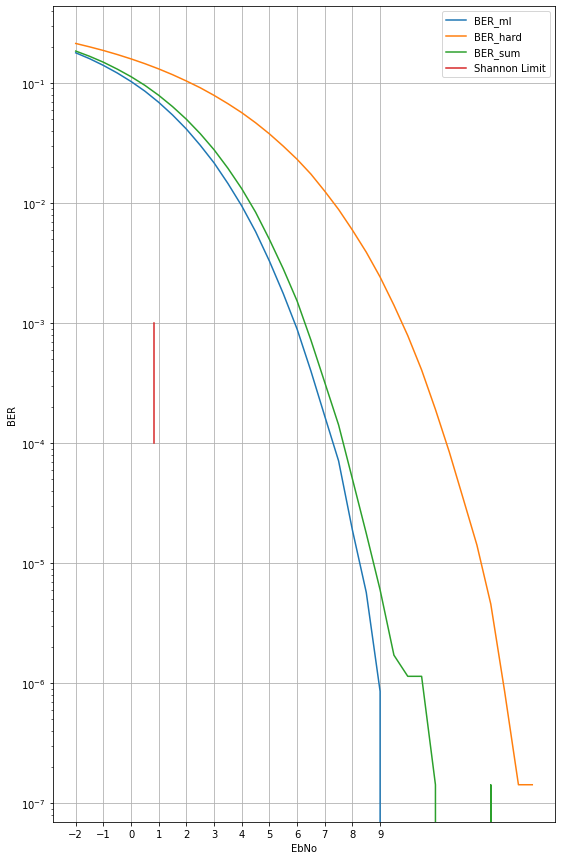

In [12]:
shannon_lim = 10.0*np.log10(2.0**(2*rate)-1)
norm_shannon_lim = 10.0*np.log10((2.0**(2*rate)-1)*rate/2)

plt.figure(figsize=(9,15), facecolor='white')
plt.semilogy(EsdB_list, ber_ml)
plt.semilogy(EsdB_list, ber_hard)
plt.semilogy(EsdB_list, ber_sum)
plt.semilogy([shannon_lim, shannon_lim], [1e-4,1e-3])
plt.legend(['BER_ml','BER_hard','BER_sum','Shannon Limit'])
plt.xlabel('EbNo')
plt.ylabel('BER')
plt.xticks(np.arange(-2,10,1))
plt.grid()
plt.savefig('output.png')